In [1]:
%reload_ext autoreload
%autoreload 2

import os
import logging
import multiprocessing
from pathlib import Path
from tqdm import tqdm

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import scipy.stats as stats
import numpyro
from numpyro.diagnostics import hpdi

from hbmep.config import Config
# from hbmep_paper.simulator import HierarchicalBayesianModel
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)

In [2]:
# import numpyro.distributions as dist
# from hbmep.model import Baseline
# from hbmep_paper.utils.constants import HBM


# class HierarchicalBayesianModel(Baseline):
#     LINK = HBM

#     def __init__(self, config: Config):
#         super(HierarchicalBayesianModel, self).__init__(config=config)
#         self.combination_columns = self.features + [self.subject]

#     def _model(self, subject, features, intensity, response_obs=None):
#         intensity = intensity.reshape(-1, 1)
#         intensity = np.tile(intensity, (1, self.n_response))

#         feature0 = features[0].reshape(-1,)

#         n_data = intensity.shape[0]
#         n_subject = np.unique(subject).shape[0]
#         n_feature0 = np.unique(feature0).shape[0]

#         global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))
#         global_sigma_v = numpyro.sample("global_sigma_v", dist.HalfNormal(100))

#         global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(10))
#         global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(500))

#         global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(5))
#         global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(5))

#         with numpyro.plate(site.n_response, self.n_response, dim=-1):
#             with numpyro.plate("n_feature0", n_feature0, dim=-2):
#                 """ Hyper-priors """
#                 mu_a = numpyro.sample(
#                     site.mu_a,
#                     dist.TruncatedNormal(50, 50, low=0)
#                 )
#                 sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(50))

#                 sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(global_sigma_b))
#                 sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(global_sigma_v))

#                 sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(global_sigma_L))
#                 sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(global_sigma_H))

#                 sigma_g_1 = numpyro.sample("sigma_g_1", dist.HalfNormal(global_sigma_g_1))
#                 sigma_g_2 = numpyro.sample("sigma_g_2", dist.HalfNormal(global_sigma_g_2))

#                 with numpyro.plate(site.n_subject, n_subject, dim=-3):
#                     """ Priors """
#                     a = numpyro.sample(
#                         site.a,
#                         dist.TruncatedNormal(mu_a, sigma_a, low=0)
#                     )
#                     b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))
#                     v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

#                     L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
#                     H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))

#                     g_1 = numpyro.sample(site.g_1, dist.Exponential(sigma_g_1))
#                     g_2 = numpyro.sample(site.g_2, dist.Exponential(sigma_g_2))

#         """ Model """
#         mu = numpyro.deterministic(
#             site.mu,
#             L[subject, feature0]
#             + jnp.maximum(
#                 0,
#                 -1
#                 + (H[subject, feature0] + 1)
#                 / jnp.power(
#                     1
#                     + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
#                     * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
#                     1 / v[subject, feature0]
#                 )
#             )
#         )
#         beta = numpyro.deterministic(
#             site.beta,
#             g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
#         )

#         """ Observation """
#         with numpyro.plate(site.data, n_data):
#             return numpyro.sample(
#                 site.obs,
#                 dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
#                 obs=response_obs
#             )


In [3]:
import numpyro.distributions as dist
from hbmep.model import Baseline
from hbmep_paper.utils.constants import HBM


class HierarchicalBayesianModel(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        global_sigma_a = numpyro.sample("global_sigma_a", dist.HalfNormal(50))

        global_sigma_b = numpyro.sample("global_sigma_b", dist.HalfNormal(100))
        global_sigma_v = numpyro.sample("global_sigma_v", dist.HalfNormal(100))

        global_sigma_L = numpyro.sample("global_sigma_L", dist.HalfNormal(1))
        global_sigma_H = numpyro.sample("global_sigma_H", dist.HalfNormal(5))

        global_sigma_g_1 = numpyro.sample("global_sigma_g_1", dist.HalfNormal(10))
        global_sigma_g_2 = numpyro.sample("global_sigma_g_2", dist.HalfNormal(10))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                """ Hyper-priors """
                mu_a = numpyro.sample(
                    site.mu_a,
                    dist.TruncatedNormal(20, 50, low=0)
                )

                sigma_a_raw = numpyro.sample("sigma_a_raw", dist.HalfNormal(scale=1))
                sigma_a = numpyro.deterministic(site.sigma_a, global_sigma_a * sigma_a_raw)

                sigma_b_raw = numpyro.sample("sigma_b_raw", dist.HalfNormal(scale=1))
                sigma_b = numpyro.deterministic(site.sigma_b, global_sigma_b * sigma_b_raw)

                sigma_v_raw = numpyro.sample("sigma_v_raw", dist.HalfNormal(scale=1))
                sigma_v = numpyro.deterministic(site.sigma_v, global_sigma_v * sigma_v_raw)

                sigma_L_raw = numpyro.sample("sigma_L_raw", dist.HalfNormal(scale=1))
                sigma_L = numpyro.deterministic(site.sigma_L, global_sigma_L * sigma_L_raw)

                sigma_H_raw = numpyro.sample("sigma_H_raw", dist.HalfNormal(scale=1))
                sigma_H = numpyro.deterministic(site.sigma_H, global_sigma_H * sigma_H_raw)

                sigma_g_1_raw = numpyro.sample("sigma_g_1_raw", dist.Exponential(rate=1))
                sigma_g_1 = numpyro.deterministic("sigma_g_1", (1 / global_sigma_g_1) * sigma_g_1_raw)

                sigma_g_2_raw = numpyro.sample("sigma_g_2_raw", dist.Exponential(rate=1))
                sigma_g_2 = numpyro.deterministic("sigma_g_2", (1 / global_sigma_g_2) * sigma_g_2_raw)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a = numpyro.sample(
                        site.a,
                        dist.TruncatedNormal(mu_a, sigma_a, low=0)
                    )

                    b_raw = numpyro.sample("b_raw", dist.HalfNormal(scale=1))
                    b = numpyro.deterministic(site.b, sigma_b * b_raw)

                    v_raw = numpyro.sample("v_raw", dist.HalfNormal(scale=1))
                    v = numpyro.deterministic(site.v, sigma_v * v_raw)

                    L_raw = numpyro.sample("L_raw", dist.HalfNormal(scale=1))
                    L = numpyro.deterministic(site.L, sigma_L * L_raw)

                    H_raw = numpyro.sample("H_raw", dist.HalfNormal(scale=1))
                    H = numpyro.deterministic(site.H, sigma_H * H_raw)

                    g_1_raw = numpyro.sample("g_1_raw", dist.Exponential(rate=1))
                    g_1 = numpyro.deterministic(site.g_1, (1 / sigma_g_1) * g_1_raw)

                    g_2_raw = numpyro.sample("g_2_raw", dist.Exponential(rate=1))
                    g_2 = numpyro.deterministic(site.g_2, (1 / sigma_g_2) * g_2_raw)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu)
        )

        # """ Penalty """
        # penalty_mu_a = (jnp.fabs(mu_a) - mu_a)
        # numpyro.factor("penalty_mu_a", -penalty_mu_a)

        # penalty_a = (jnp.fabs(a) - a)
        # numpyro.factor("penalty_a", -penalty_a)

        # penalty_b = (b)
        # numpyro.factor("penalty_b", -penalty_b)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [4]:
root_path = Path(os.getcwd()).parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/human/tms/fit.toml")

config = Config(toml_path=toml_path)

# config.MCMC_PARAMS["num_warmup"] = 10000
# # config.MCMC_PARAMS["num_chains"] = 4

model = HierarchicalBayesianModel(config=config)


2023-10-09 13:44:08,305 - hbmep.config - INFO - Verifying configuration ...
2023-10-09 13:44:08,306 - hbmep.config - INFO - Success!
2023-10-09 13:44:08,319 - hbmep.model.baseline - INFO - Initialized model with hierarchical_bayesian link


In [5]:
src = "/home/vishu/data/hbmep-processed/human/tms/data_pkpk_auc.csv"
df = pd.read_csv(src)

# subset = ["SCA01"]
# # subset = ["SCS03"]
# ind = df[model.subject].isin(subset)
# df = df[ind].reset_index(drop=True).copy()

df, encoder_dict = model.load(df=df)


2023-10-09 13:44:08,383 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/tms/fit
2023-10-09 13:44:08,383 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/tms/fit
2023-10-09 13:44:08,384 - hbmep.dataset.core - INFO - Processing data ...
2023-10-09 13:44:08,385 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [6]:
mcmc, posterior_samples = model.run_inference(df=df)


2023-10-09 13:44:08,460 - hbmep.model.baseline - INFO - Running inference with hierarchical_bayesian ...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

2023-10-09 13:54:27,352 - hbmep.utils.utils - INFO - func:run_inference took: 10 min and 18.89 sec


In [8]:
mcmc.print_summary(prob=.95)



                        mean       std    median      2.5%     97.5%     n_eff     r_hat
      H_raw[0,0,0]      0.82      0.61      0.70      0.01      1.94    550.97      1.01
      H_raw[0,0,1]      0.82      0.60      0.68      0.00      1.97    515.62      1.00
      H_raw[0,0,2]      0.80      0.62      0.65      0.00      2.00    248.52      1.01
      H_raw[0,0,3]      0.76      0.59      0.63      0.00      1.91    311.18      1.01
      H_raw[0,0,4]      0.88      0.58      0.79      0.02      2.03    544.64      1.01
      H_raw[0,0,5]      0.81      0.61      0.70      0.00      2.01    341.04      1.01
      H_raw[0,1,0]      0.87      0.37      0.80      0.29      1.63     75.84      1.07
      H_raw[0,1,1]      0.51      0.14      0.50      0.26      0.78     58.62      1.07
      H_raw[0,1,2]      0.66      0.58      0.51      0.00      1.80    302.37      1.03
      H_raw[0,1,3]      0.55      0.19      0.54      0.21      0.94     64.81      1.05
      H_raw[0,1,4]  

In [9]:
mcmc.print_summary(prob=.95)

prediction_df = model.make_prediction_dataset(df=df)

posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)

model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-10-09 13:55:53,137 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec



                        mean       std    median      2.5%     97.5%     n_eff     r_hat
      H_raw[0,0,0]      0.82      0.61      0.70      0.01      1.94    550.97      1.01
      H_raw[0,0,1]      0.82      0.60      0.68      0.00      1.97    515.62      1.00
      H_raw[0,0,2]      0.80      0.62      0.65      0.00      2.00    248.52      1.01
      H_raw[0,0,3]      0.76      0.59      0.63      0.00      1.91    311.18      1.01
      H_raw[0,0,4]      0.88      0.58      0.79      0.02      2.03    544.64      1.01
      H_raw[0,0,5]      0.81      0.61      0.70      0.00      2.01    341.04      1.01
      H_raw[0,1,0]      0.87      0.37      0.80      0.29      1.63     75.84      1.07
      H_raw[0,1,1]      0.51      0.14      0.50      0.26      0.78     58.62      1.07
      H_raw[0,1,2]      0.66      0.58      0.51      0.00      1.80    302.37      1.03
      H_raw[0,1,3]      0.55      0.19      0.54      0.21      0.94     64.81      1.05
      H_raw[0,1,4]  

2023-10-09 13:56:00,733 - hbmep.utils.utils - INFO - func:predict took: 7.60 sec
2023-10-09 13:56:00,836 - hbmep.model.baseline - INFO - Rendering ...
2023-10-09 13:56:08,800 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/recruitment_curves.pdf
2023-10-09 13:56:08,803 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 8.07 sec
2023-10-09 13:56:08,932 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-09 13:56:19,021 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/posterior_predictive_check.pdf
2023-10-09 13:56:19,022 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 10.22 sec
2023-10-09 13:56:19,022 - hbmep.utils.utils - INFO - func:render_predictive_check took: 10.22 sec


In [24]:
(posterior_samples[site.beta] * posterior_samples[site.mu] <= 0).sum()

Array(0, dtype=int64)

In [18]:
type(mcmc)

numpyro.infer.mcmc.MCMC

In [8]:
ps = mcmc.get_samples(group_by_chain=True)
a = ps[site.a]
a.shape

(10, 1000, 1, 1, 6)

In [9]:
sns.kdeplot(a[3, ..., *c].reshape(-1,))

NameError: name 'c' is not defined

In [16]:
L = ps[site.L]
sigma_L = ps[site.sigma_L]
b = ps[site.b]
v = ps[site.v]

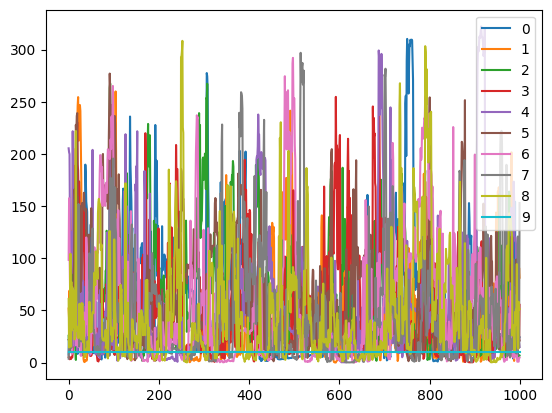

In [18]:
c = (0, 0, 0)

var = v

chain = 0
sns.lineplot(y=var[chain, ..., *c], x=np.arange(0, 1000, 1), label=f"{chain}")

chain = 1
sns.lineplot(y=var[chain, ..., *c], x=np.arange(0, 1000, 1), label=f"{chain}")

chain = 2
sns.lineplot(y=var[chain, ..., *c], x=np.arange(0, 1000, 1), label=f"{chain}")

chain = 3
sns.lineplot(y=var[chain, ..., *c], x=np.arange(0, 1000, 1), label=f"{chain}")

chain = 4
sns.lineplot(y=var[chain, ..., *c], x=np.arange(0, 1000, 1), label=f"{chain}")

chain = 5
sns.lineplot(y=var[chain, ..., *c], x=np.arange(0, 1000, 1), label=f"{chain}")

chain = 6
sns.lineplot(y=var[chain, ..., *c], x=np.arange(0, 1000, 1), label=f"{chain}")

chain = 7
sns.lineplot(y=var[chain, ..., *c], x=np.arange(0, 1000, 1), label=f"{chain}")

chain = 8
sns.lineplot(y=var[chain, ..., *c], x=np.arange(0, 1000, 1), label=f"{chain}")

chain = 9
sns.lineplot(y=var[chain, ..., *c], x=np.arange(0, 1000, 1), label=f"{chain}")


plt.legend()


In [8]:
mcmc.print_summary(prob=.95)


                        mean       std    median      2.5%     97.5%     n_eff     r_hat
          H[0,0,0] 137601.88 1106451.73   7645.16      0.77 574079.50    409.20      1.02
          H[0,0,1] 128726.10 985487.98   8443.50      0.33 516634.79    832.18      1.01
          H[0,0,2]  63278.85 194856.32   8207.34      0.04 304552.95    264.32      1.01
          H[0,0,3]  72778.41 355621.14   5977.30      0.03 236385.95    429.81      1.01
          H[0,0,4] 410962.88 16437947.57   7536.30      0.05 429725.48   2284.73      1.00
          H[0,0,5] 348075.35 5653415.35   7767.46      0.05 273627.52    552.62      1.01
          L[0,0,0]      0.02      0.01      0.02      0.00      0.05    188.44      1.02
          L[0,0,1]      0.04      0.04      0.03      0.00      0.12    142.11      1.04
          L[0,0,2]      0.01      0.01      0.01      0.00      0.02    155.12      1.02
          L[0,0,3]      0.02      0.01      0.02      0.00      0.04    245.85      1.02
          L[0,0,

In [9]:
prediction_df = model.make_prediction_dataset(df=df)

posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)

model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples, prediction_df=prediction_df, posterior_predictive=posterior_predictive)

model.render_predictive_check(df=df, encoder_dict=encoder_dict, prediction_df=prediction_df, posterior_predictive=posterior_predictive)


2023-10-09 10:32:49,383 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2023-10-09 10:32:50,658 - hbmep.utils.utils - INFO - func:predict took: 1.27 sec
2023-10-09 10:32:50,663 - hbmep.model.baseline - INFO - Rendering ...
2023-10-09 10:32:51,774 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/recruitment_curves.pdf
2023-10-09 10:32:51,774 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 1.12 sec
2023-10-09 10:32:51,781 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-10-09 10:32:53,032 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/posterior_predictive_check.pdf
2023-10-09 10:32:53,033 - hbmep.utils.utils - INFO - func:_render_predictive_check took: 1.26 sec
2023-10-09 10:32:53,033 - hbmep.utils.utils - INFO - func:render_predictive_check took: 1.26 sec


In [10]:
import pickle

dest = os.path.join(model.build_dir, "inference.pkl")
with open(dest, "wb") as f:
    pickle.dump((model, mcmc, posterior_samples), f)

In [11]:
import pickle

with open(dest, "rb") as g:
    model_, mcmc_, posterior_samples_ = pickle.load(g)


In [16]:
dest

'/home/vishu/repos/hbmep-paper/reports/human/tms/fit/inference.pkl'